## SSD를 이용한 Object Detection 실행

기본 base model으로 MobilenetV2를 받아서 SSD를 활용한 object detection을 수행한다.<br>
이 실습은 box로 embedding된 MNIST 이미지에 대한 bounding box를 만드는 것을 목적으로 한다.<br>
각각의 box는 하나의 digit을 가지며, 224X224 크기의 box 안에 28X28 크기의 MNIST 숫자가 들어있다.<br>
그러나 각각의 이미지 예측 개수는 쉽게 확장 가능하다. 또한, 현재는 data augmentation은 활용되고 있지 않다. <br>

In [1]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy.matlib
import matplotlib.pyplot as patches
from PIL import Image
from keras import backend as K

from scipy.special import softmax
import bottleneck

In [2]:
#Make Bottleneck Residual layer for MobileNetV2
class Bottleneck(keras.Model):
    def __init__(self, expansion, stride, block_id, filters, alpha=1):
        super(Bottleneck, self).__init__(name="Bottleneck_" + block_id)
        self.stride = stride
        self.expansion = expansion
        self.alpha = alpha
        self.output_channels = self.alpha * filters
        self.out = None
        
        prefix = "Bottleneck_{}_".format(block_id)
        self.prefix = prefix
        
        #expansion
        self.expand_BN = layers.BatchNormalization(name = prefix + 'expand_BN')
        self.expand_ReLU = layers.ReLU(max_value=6, name = prefix + 'expand_ReLU')
        
        #conv
        self.Conv = layers.DepthwiseConv2D(kernel_size=3, padding='same', strides=self.stride, use_bias=False, name = prefix + 'conv')
        self.Conv_BN = layers.BatchNormalization(name = prefix + 'conv_BN')
        self.Conv_ReLU = layers.ReLU(max_value=6, name = prefix + 'conv_ReLU')
        
        #project
        self.project = layers.Conv2D(filters = self.output_channels, kernel_size = 1, use_bias = False, name = 'contract')
        self.project_BN = layers.BatchNormalization(name = prefix + 'contract_BN')
        
        #residual connection을 위해서 dimension을 같게 만들어야 한다.
        self.residual = layers.Add(name = prefix + 'residual')
        
    def build(self, input_shape):
        self.d = input_shape[-1]
        
        self.expand = layers.Conv2D(filters = self.expansion * self.d, kernel_size = 1, use_bias = False, name = self.prefix + 'expand')
        
    def call(self, inputs):
        x = self.expand(inputs)
        x = self.expand_BN(x)
        x = self.expand_ReLU(x)
        self.out = x
        
        x = self.Conv(x)
        x = self.Conv_BN(x)
        x = self.Conv_ReLU(x)
        
        x = self.project(x)
        x = self.project_BN(x)
        
        if self.output_channels == self.d and self.stride == 1:
            x = self.residual([inputs, x])
            
        return x
    
    def model(self):
        x = keras.Input(shape = (28,28,3))
        return keras.Model(inputs = [x], outputs = self.call(x))

In [3]:
class MobileNetV2(keras.Model):
    def __init__(self, k = 11):
        super(MobileNetV2, self).__init__()
        self.conv_inp = layers.Conv2D(filters = 32, kernel_size = 3, strides = (2,2), padding = 'valid', use_bias = False, name = 'conv')
        self.k = k
        self.pad = layers.ZeroPadding2D(padding=2, name='pad')
        self.BN = layers.BatchNormalization(name='BN')
        self.ReLU = layers.ReLU(max_value = 6, name='ReLU')
        
        self.B1_1 = Bottleneck(expansion = 1, filters = 16, stride = 1, block_id = 'B1_1')

        self.B2_1 = Bottleneck(expansion = 6, filters = 24, stride = 2, block_id = 'B2_1')
        self.B2_2 = Bottleneck(expansion = 6, filters = 24, stride = 1, block_id = 'B2_2')

        self.B3_1 = Bottleneck(expansion = 6, filters = 32, stride = 2, block_id = 'B3_1')
        self.B3_2 = Bottleneck(expansion = 6, filters = 32, stride = 1, block_id = 'B3_2')
        self.B3_3 = Bottleneck(expansion = 6, filters = 32, stride = 1, block_id = 'B3_3')

        self.B4_1 = Bottleneck(expansion = 6, filters = 64, stride = 2, block_id = 'B4_1')
        self.B4_2 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_2')
        self.B4_3 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_3')
        self.B4_4 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_4')

        self.B5_1 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_1')
        self.B5_2 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_2')
        self.B5_3 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_3')

        self.B6_1 = Bottleneck(expansion = 6, filters = 160, stride = 2, block_id = 'B6_1')
        self.B6_2 = Bottleneck(expansion = 6, filters = 160, stride = 1, block_id = 'B6_2')
        self.B6_3 = Bottleneck(expansion = 6, filters = 160, stride = 1, block_id = 'B6_3')

        self.B7_1 = Bottleneck(expansion = 6, filters = 320, stride = 1, block_id = 'B7_1')
        
        self.conv_out = layers.Conv2D(filters = 1280, kernel_size = 1, strides = (1, 1), use_bias = False, name="conv_out")
        self.avgpool = layers.AveragePooling2D(pool_size = (7, 7), name='avg_pool')
        self.conv_seg = layers.Conv2D(filters = self.k, kernel_size = 1, strides = (1, 1), use_bias = False, name='conv_seg')
        
    def call(self, inputs):
        x = self.conv_inp(inputs)
        x = self.BN(x)
        x = self.ReLU(x)

        x = self.B1_1(x)
        x = self.B2_1(x)
        x = self.B2_2(x)

        x = self.B3_1(x)
        x = self.B3_2(x)
        x = self.B3_3(x)

        x = self.B4_1(x)
        x = self.B4_2(x)
        x = self.B4_3(x)
        x = self.B4_4(x)

        x = self.B5_1(x)
        x = self.B5_2(x)
        x = self.B5_3(x)

        x = self.B6_1(x)
        x = self.B6_2(x)
        x = self.B6_3(x)

        x = self.B7_1(x)

        x = self.conv_out(x)
        x = self.avgpool(x)
        c4 = self.conv_seg(x)

        return c4        

    def model(self):
        x = keras.Input(shape = (224, 224, 3))
        
        return keras.Model(inputs=x, outputs = self.call(x))       

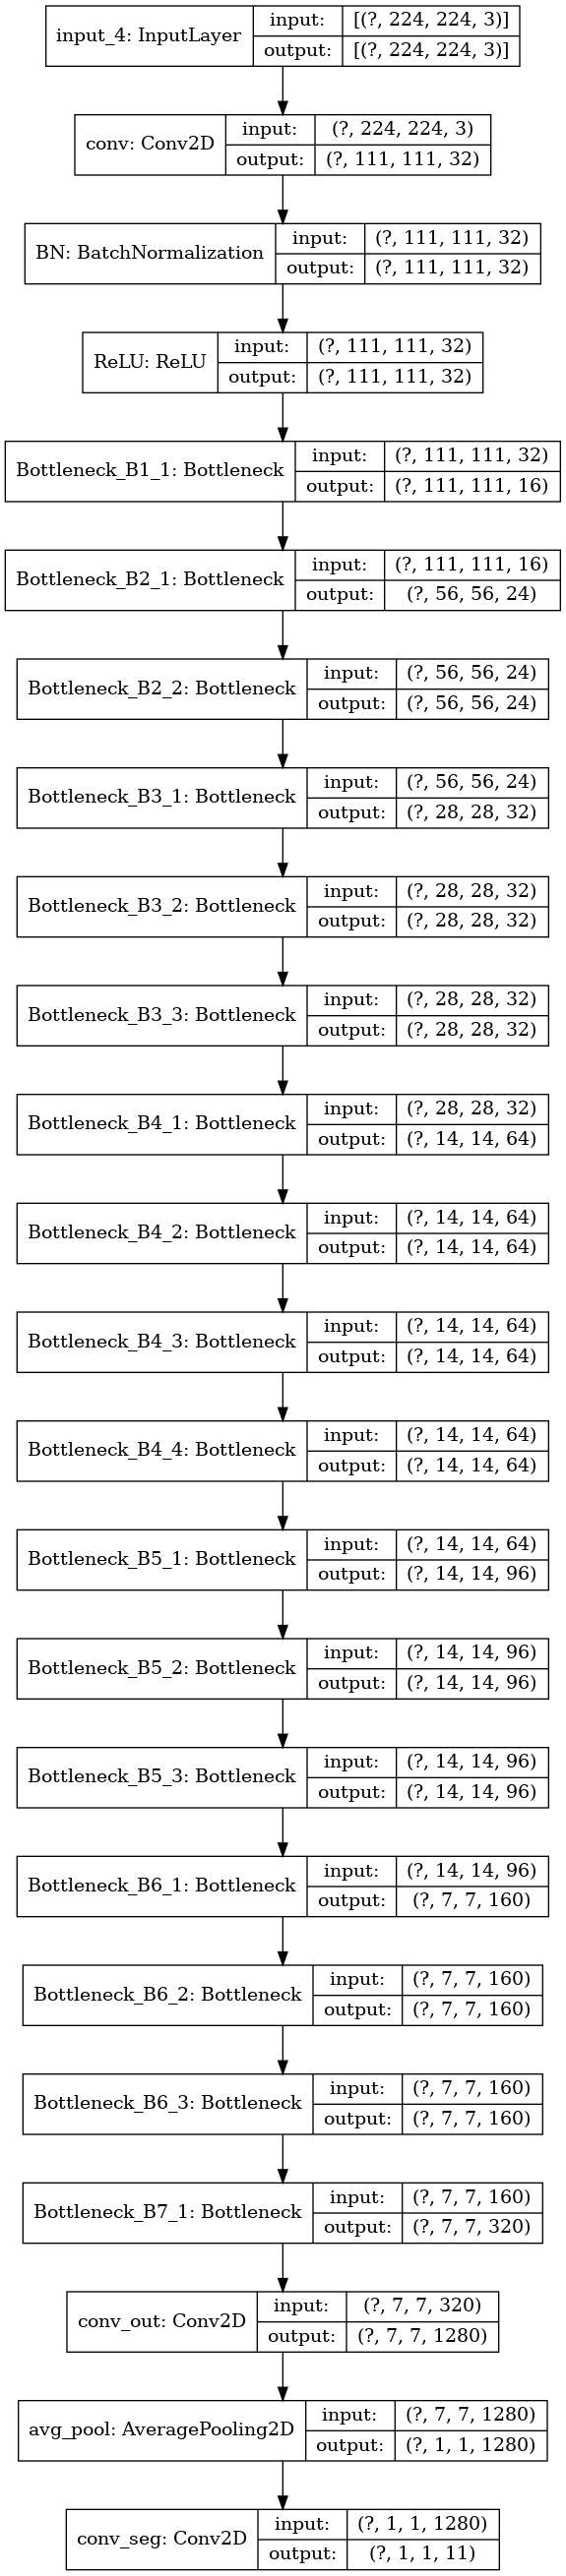

In [31]:
#MobileNetV2().model().summary()
tf.keras.utils.plot_model(MobileNetV2().model(), show_shapes=True)

In [5]:
#define SSD
#각 층에서의 박스의 수와 해상도가 다르다. 여기서는 MNIST데이터와 224 * 224 이미지에 대해서 작업을 한다. 
class SSD(keras.Model):
    def __init__(self, numBoxes=[4, 6, 6, 6, 4, 4], layerWidth = [28, 14, 7, 4, 2, 1], k = 10+1+4):
        super(SSD, self).__init__()
        self.classes = k
        self.featureMaps = 6
        self.MobileNet = MobileNetV2(k = k)
        self.numBoxes = numBoxes
        self.layerWidth = layerWidth
        self.features = [None for _ in range(self.featureMaps)]
        self.classifiers = [None for _ in (range(self.featureMaps))]
        
        self.conv1_1 = layers.Conv2D(256,1,name='SSD_conv_1_1')
        self.conv1_2 = layers.Conv2D(512,3,strides=(2,2),padding='same',name='SSD_conv_1_2')

        self.conv2_1 = layers.Conv2D(128,1,name='SSD_conv_2_1')
        self.conv2_2 = layers.Conv2D(256,3,strides=(2,2),padding='same',name='SSD_conv_2_2')
    
        self.conv3_1 = layers.Conv2D(128,1,name='SSD_conv_3_1')
        self.conv3_2 = layers.Conv2D(256,3,strides=(1,1),name='SSD_conv_3_2')
    
        self.conv4_1 = layers.Conv2D(128,1,name='SSD_conv_4_1')
        self.conv4_2 = layers.Conv2D(256,2,strides=(1,1),name='SSD_conv_4_2')
        #논문과 비교했을 때, kernel size 가 2로 바뀐듯 이전 width가 3이라서
        self.conv = []                                   
        self.reshape = []
        for i in range(self.featureMaps):
            self.conv.append(layers.Conv2D(self.numBoxes[i]*self.classes,3,padding='same',name='Classification_'+str(i)))
            self.reshape.append(layers.Reshape((self.layerWidth[i]* self.layerWidth[i] * self.numBoxes[i],self.classes),name='Reshape_classification_'+str(i)))  
    def build(self, input_shape):
        self.MobileNet.build(input_shape)
    
    def call(self, inputs):
        x = inputs
        x = self.MobileNet(x)

        #다양한 해상도에 대해서 이미지들을 뽑아낸다.
        self.features[0] = self.MobileNet.get_layer('Bottleneck_B4_1').out
        self.features[1] = self.MobileNet.get_layer('Bottleneck_B5_3').out
        self.features[2] = self.conv1_2(self.conv1_1(self.features[1]))
        self.features[3] = self.conv2_2(self.conv2_1(self.features[2]))
        self.features[4] = self.conv3_2(self.conv3_1(self.features[3]))
        self.features[5] = self.conv4_2(self.conv4_1(self.features[4]))

        #각 feature map에 대해서 layer, output ch의 수에 대한 박스의 숫자에 따른 예측값을 만든다.
        for i in range(self.featureMaps):
            x = self.conv[i](self.features[i])
            x = self.reshape[i](x)
            self.classifiers[i] = x
        
        #모든 classifier들을 연결시킨다.
        x = layers.concatenate(self.classifiers, axis = -2, name='concatenate')
        return x
    
    def model(self):
        x = keras.Input(shape=(224, 224, 3))
        return keras.Model(inputs = x, outputs = self.call(x))

In [6]:
NUM_CLASSES = 10

#처음 2개의 dimension은 bottleneck expand ReLU (4,1), (5,3)에서 각각 결과로 나온 결과의 width와 같아져야 한다.
#2번째 이후의 dimension들은 SSD 내부에서 써진 conv에 의해서 결정된다. (conv1_2, conv2_2, conv3_2, conv4_2)
layerWidths = [28, 14, 7, 4, 2, 1]
numBoxes = [3,3,3,3,3,3]

#각 layer에 해당하도록 width와 box가 정해져야 한다.
assert len(numBoxes) == len(layerWidths)

#원래 class에 background, x, y, h, w를 더한다.
outputChannels = NUM_CLASSES + 1 + 4
assert outputChannels - NUM_CLASSES == 5

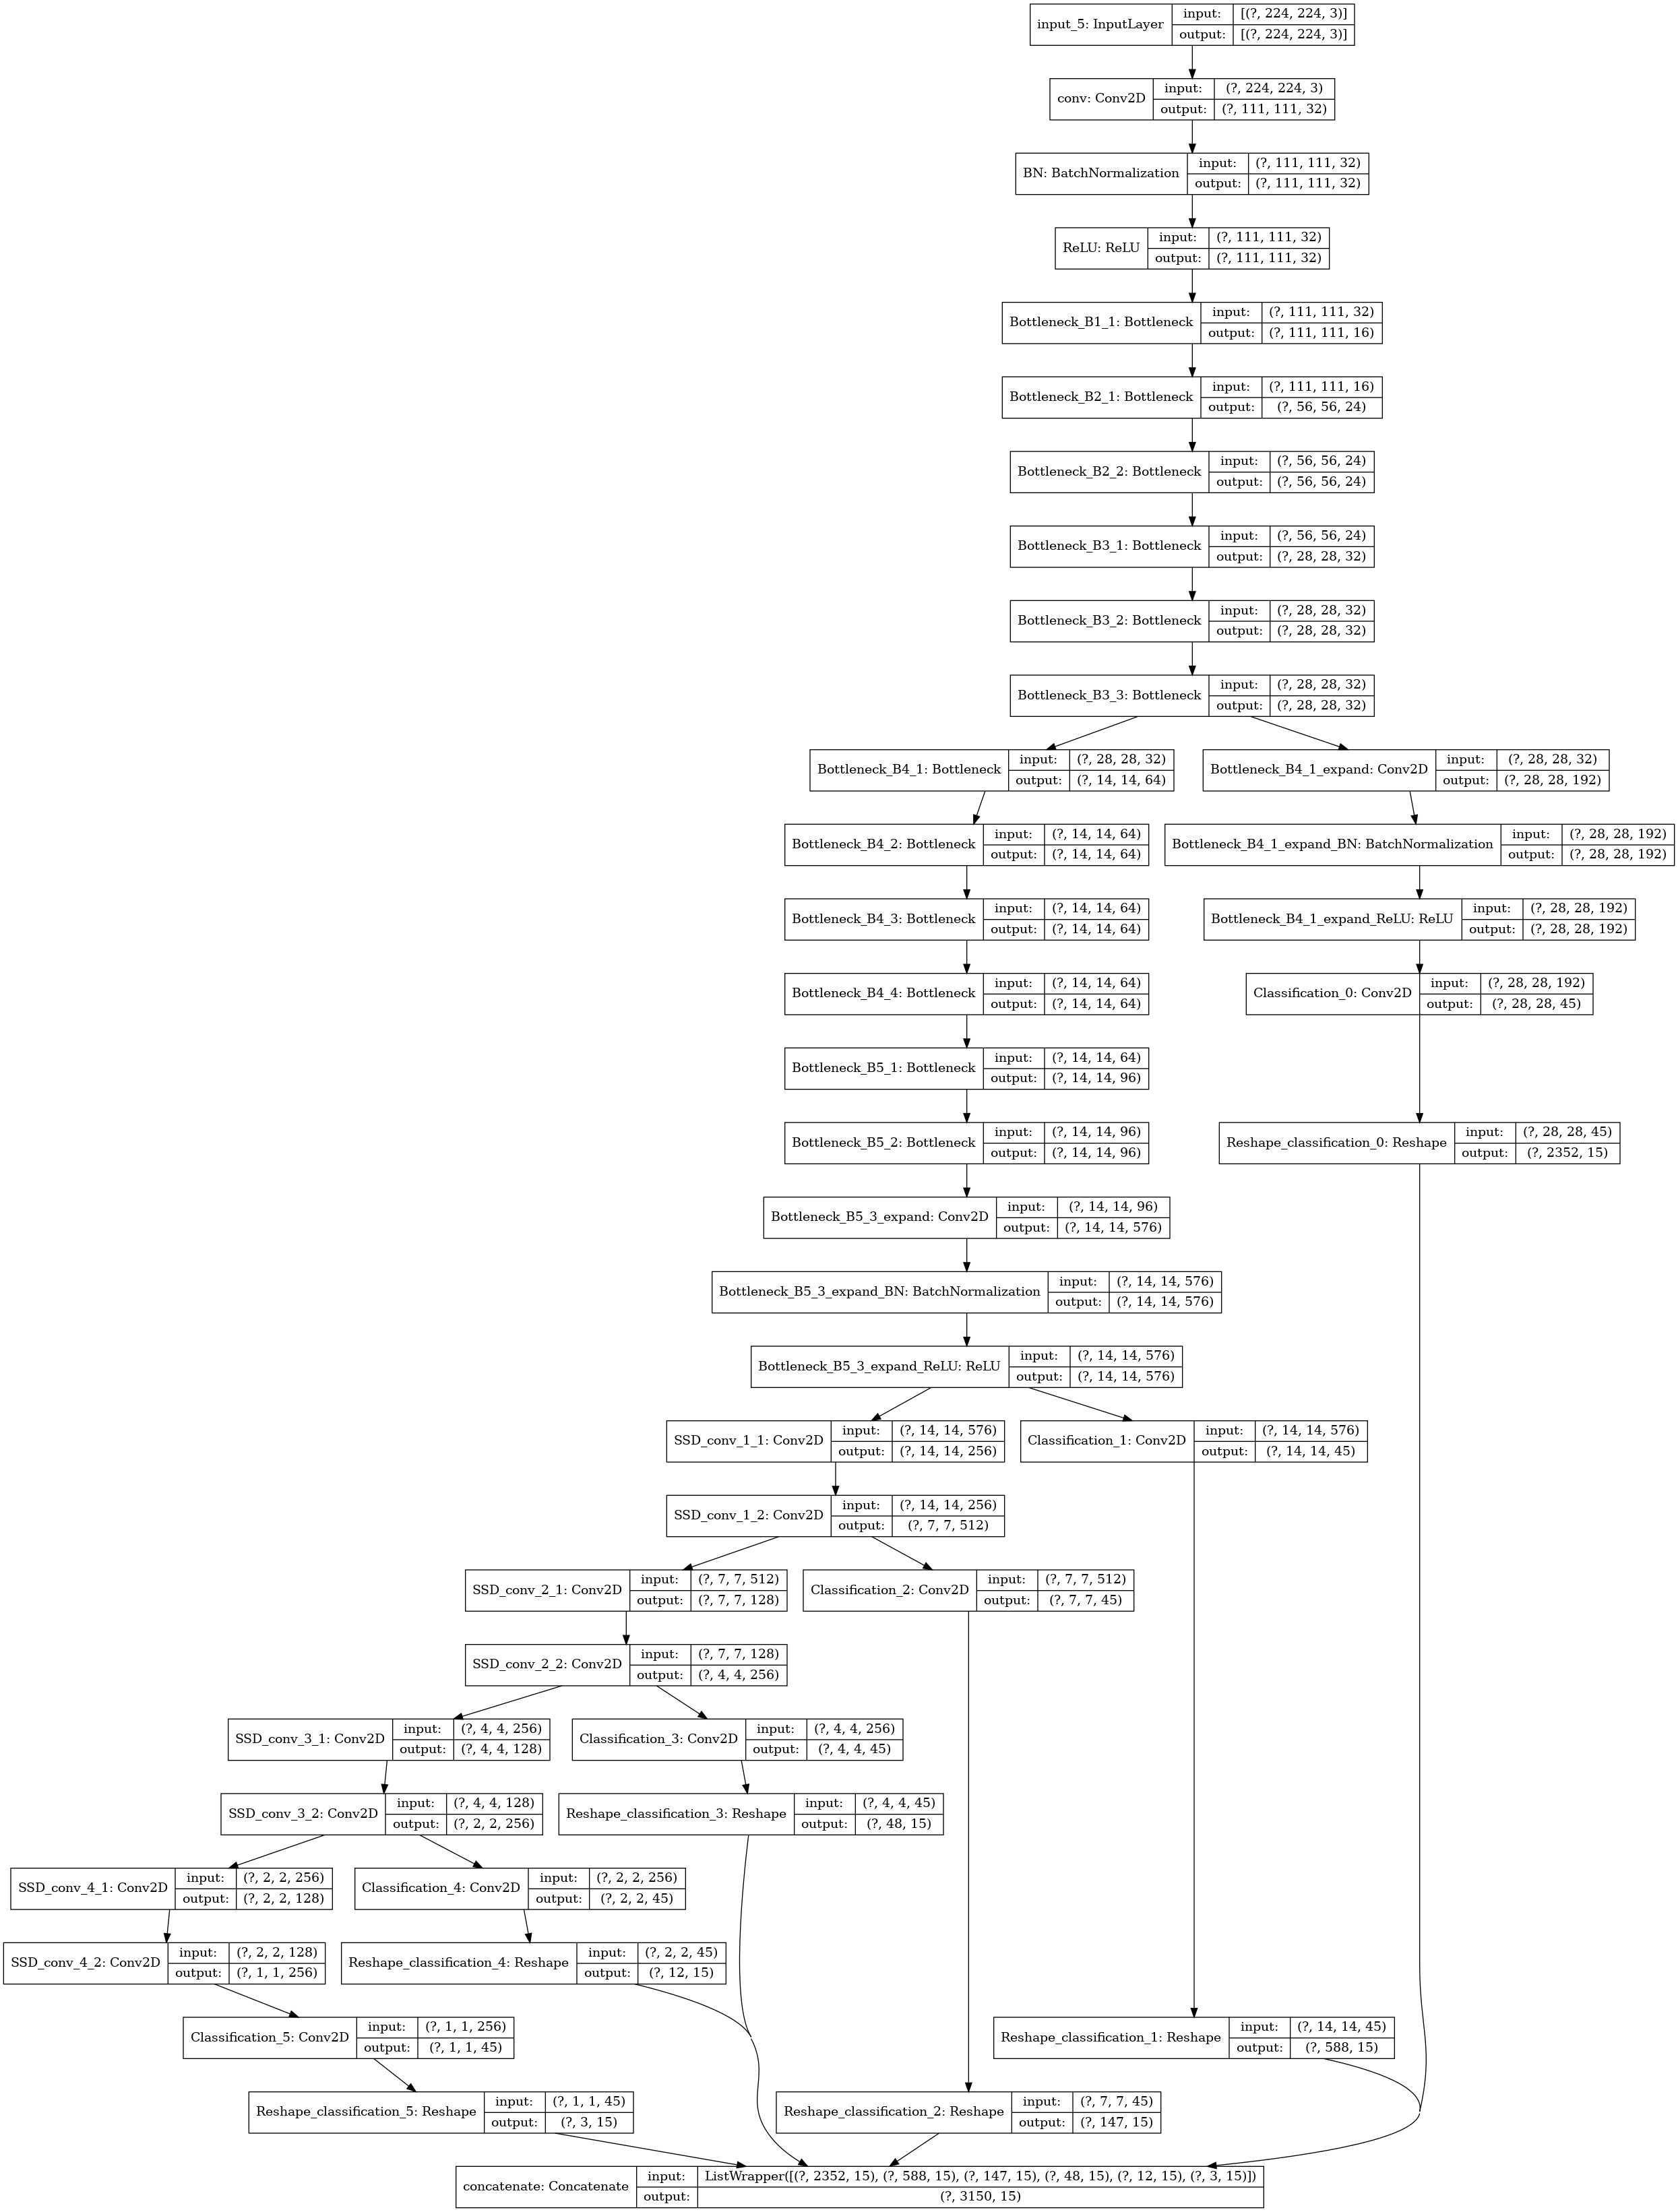

In [32]:
model = SSD(numBoxes = numBoxes, layerWidth = layerWidths, k = outputChannels)
#model.model().summary()
tf.keras.utils.plot_model(model.model(), show_shapes=True)

In [8]:
#Box와 IOU를 만든다.
#데이터셋이 이미 균일하기 때문에, 다양하지 못한 scale과 aspect ratio를 사용한다.
#scale의 크기는 layer width의 숫자, 즉 얼마나 다양한 해상도를 쓰는지와 같다.
#주어진 해상도에 대해서 다른 aspect ratio를 갖는다.
# num(scales) = num(layerWidth) = num(numBoxes), num(asp_ratios) = numBoxes[i]

MinScale = 0.1
MaxScale = 1.5

#layerWidth가 높은 곳에서 낮은곳으로 가기 때문에 순서를 반대로 해야한다. (해상도를 점점 올리기 위해서)
scales = [MinScale + x/len(layerWidths) * (MaxScale-MinScale) for x in range(len(layerWidths))]
scales = scales[::-1]

asp = [0.5, 1.0, 1.5]
asp1 = [x**0.5 for x in asp]
asp2 = [1/x for x in asp1]

In [9]:
IMG_SIZE = 224
# 이것은 SSD 모델의 output layer의 첫번째 dim과 같아야 한다.
BOXES = sum([a*a*b for a, b in zip(layerWidths, numBoxes)])
print(BOXES)

centres = np.zeros((BOXES, 2))
hw = np.zeros((BOXES,2))
boxes = np.zeros((BOXES, 4))

3150


In [10]:
# calculating the default box centres and height, width
idx = 0

for gridSize, numBox, scale in zip(layerWidths,numBoxes,scales):
    
    step_size = IMG_SIZE*1.0/gridSize
    for i in range(gridSize):
        for j in range(gridSize):
            pos = idx + (i*gridSize+j) * numBox
      # centre is the same for all aspect ratios(=numBox)
            centres[ pos : pos + numBox , :] = i*step_size + step_size/2, j*step_size + step_size/2
      # height and width vary according to the scale and aspect ratio
      # zip asepct ratios and then scale them by the scaling factor
            hw[ pos : pos + numBox , :] = np.multiply(gridSize*scale, np.squeeze(np.dstack([asp1,asp2]),axis=0))[:numBox,:]

    idx += gridSize*gridSize*numBox 

In [11]:
# (x,y) co-ordinates of top left and bottom right
# This actually is not used anywhere. centres[] and hw[] are a good enough substitute
boxes[:,0] = centres[:,0] - hw[:,0]/2
boxes[:,1] = centres[:,1] - hw[:,1]/2
boxes[:,2] = centres[:,0] + hw[:,0]/2
boxes[:,3] = centres[:,1] + hw[:,1]/2

In [12]:
# calculate IoU for a set of search boxes and default boxes
def IoU(box1, box2):
    box1 = box1.astype(np.float64)
    box2 = box2.astype(np.float64)
    # find the left and right co-ordinates of the edges. Min should be less than Max for non zero overlap
    xmin = np.maximum(box1[:,0],box2[:,0])
    xmax = np.minimum(box1[:,2],box2[:,2])
    ymin = np.maximum(box1[:,1],box2[:,1])
    ymax = np.minimum(box1[:,3],box2[:,3])

    intersection = np.abs(np.maximum(xmax-xmin,0) * np.maximum(ymax-ymin,0))
    boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
    boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
    unionArea = boxArea1 + boxArea2 - intersection
    assert (unionArea > 0).all()
    iou = intersection / unionArea

    return iou

In [13]:
# give the index of the box correpsonding to the IoUs > threshold (=0.5) 
def bestIoU(searchBox):
    return np.argwhere(IoU(numpy.matlib.repmat(searchBox,BOXES,1), boxes) > 0.5)

In [14]:
TRAINSIZE = 600
TESTSIZE = 100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:TRAINSIZE , : , :]
y_train = y_train[:TRAINSIZE]
x_test = x_test[:TESTSIZE , : , :]
y_test = y_test[:TESTSIZE]

In [15]:
# take mnist x and y pairs and convert to input, output pairs for the MobileNetv2+SSD model
def convert(x,y):
    MNIST_SIZE = x.shape[-1]
    # create a 2D array of top left corners for the mnist image to be placed
    corner = np.random.randint(IMG_SIZE - MNIST_SIZE, size=(x.shape[0],2))

    # create a blank canvas for the input with the required dimension
    input = np.zeros((x.shape[0], IMG_SIZE, IMG_SIZE, 3))

    # replacing a part by RGB version of MNIST
    for i in range(x.shape[0]):
        lx = int(corner[i,0])
        ly = int(corner[i,1])
        input[i,lx:lx + MNIST_SIZE, ly:ly+MNIST_SIZE,:] = np.repeat(np.expand_dims(np.array(x[i,:,:]),axis=-1),3,axis=-1)

    # for each default box, there are 5 values: class number and delta cx,cy,h,w
    output = np.zeros((y.shape[0],BOXES,1+4))
    output[:,:,0] = NUM_CLASSES # defaulting class labels for all boxes to background initially
    for i in range(x.shape[0]):
        bbox = np.zeros(4)
        bbox[:2] = corner[i]
        bbox[2:] = corner[i] + (MNIST_SIZE,MNIST_SIZE)
        # for all default boxes which have IoU > threshold, set the delta values and class number
        box_idx = bestIoU(bbox).astype(np.uint16)
        output[i,box_idx,0] = y[i]
        output[i,box_idx,1] = (bbox[0] + bbox[2])/2.0 - centres[box_idx,0]
        output[i,box_idx,2] = (bbox[1] + bbox[3])/2.0 - centres[box_idx,1]
        output[i,box_idx,3] = MNIST_SIZE - hw[box_idx,0]
        output[i,box_idx,4] = MNIST_SIZE - hw[box_idx,1]

    return input, output


In [16]:
test_x, test_y = convert(x_test,y_test)
train_x, train_y = convert(x_train,y_train)

Number of boxes with IoU > 0.5: 8
Green box: ground truth. Red box: default boxes with IoU > threshold


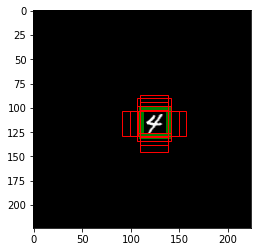

In [17]:
# checking if the inputs prepared are correct or not
r = np.random.randint(0,train_x.shape[0])
img = train_x[r,:,:,:].copy()
img_y = train_y[r]

im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

# find all boxes where class label is not background
idx = np.argwhere(img_y[:,0] != NUM_CLASSES)[:,0]
print('Number of boxes with IoU > 0.5:',idx.shape[0])
print('Green box: ground truth. Red box: default boxes with IoU > threshold')

#calculating the ground truth bounding boxes
gt = np.zeros(4,dtype=np.uint16)
gt[:2] = (img_y[idx[0],1:3] + centres[idx[0],:2])
gt[2:] = (img_y[idx[0],3:] + hw[idx[0],:])

# for some reason, x and y are inverted
rect = patches.Rectangle((gt[1]-gt[3]/2,gt[0]-gt[2]/2),gt[3],gt[2],linewidth=5,edgecolor='g',facecolor='none')
ax.add_patch(rect)

# showing all the boxes with IoU > 0.5
for i in idx:
    rect = patches.Rectangle((centres[i][1]-hw[i,1]/2,centres[i][0]-hw[i,0]/2),hw[i,1],hw[i,0],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))
(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))


In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 60

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [20]:
# label is not required here in the standard implementation
# calculate the smooth L1 loss
def smoothL1(x,y,label):
    diff = K.abs(x-y) #* K.switch(label == 10, label*1.0/BOXES, label)
    result = K.switch(diff < 1, 0.5 * diff**2, diff - 0.5)
    return K.mean(result)

In [21]:
def confidenceLoss(y,label):
    unweighted_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(label, y)
    # class_weights = tf.constant([[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0/BOXES]]*BOXES])
    # weights = tf.reduce_sum(class_weights * y, axis = -1)
    # weighted_loss = unweighted_loss * weights
    return K.mean(unweighted_loss)

In [22]:
def Loss(gt,y):
    # shape of y is n * BOXES * output_channels
    # shape of gt is n * BOXES * 5 
    loss = 0
    # localisation loss
    loss += smoothL1(y[:,:,-4:],gt[:,:,-4:],gt[:,:,0:1])
    # confidence loss
    loss += confidenceLoss(y[:,:,:-4],tf.cast(gt[:,:,0],tf.int32))
    return loss

In [23]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),loss=Loss)

In [24]:
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data = test_dataset)

Epoch 1/25

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



60/60 [==============================] - 4s 63ms/step - loss: 0.4194 - val_loss: 0.3936
Epoch 2/25
60/60 [==============================] - 3s 55ms/step - loss: 0.0854 - val_loss: 0.0554
Epoch 3/25
60/60 [==============================] - 3s 55ms/step - loss: 0.0602 - val_loss: 0.0458
Epoch 4/25
60/60 [==============================] - 3s 54ms/step - loss: 0.0509 - val_loss: 0.0297
Epoch 5/25
60/60 [==============================] - 3s 55ms/step - loss: 0.0280 - val_loss: 0.0254
Epoch 6/25
60/60 [==============================] - 3s 57ms/step - loss: 0.0357 - val_loss: 0.0233
Epoch 7/25
60/60 [==============================] - 3s 56ms/step - loss: 0.0265 - val_loss: 0.0479
Epoch 8/25
60/60 [==============================] - 3s 55ms/step - loss: 0.0176 - val_loss: 0.0173
Epoch 9/25
60/60 [==============================] - 3s 55ms/step - loss: 0.0241 - val_loss: 0.0170
Epoch 10/25
60/60 [==============================] - 3s 55ms/step - loss: 0.0189 - val_loss: 0.0145
Epoch 11/25
60/60 [=

In [25]:
model.evaluate(test_x,test_y)

4/4 [==============================] - 0s 47ms/step - loss: 0.0196


0.019617415964603424

In [26]:
# create some sample data
X, Y = convert(x_test, y_test)

In [27]:
# get prediction for one sample
y_pred = model.predict(X)
y_pred.shape

(100, 3150, 15)

In [28]:
OBJperCLASS = 10 # get the top 10 results for each class
# get the confidence scores (with class values) and delta for the boxes. For each class, the top 10 values are used
def infer(Y):
  # classes are actually the index into the default boxes
    classes = np.zeros((OBJperCLASS,outputChannels-4),dtype=np.uint16)
    conf = np.zeros((OBJperCLASS,outputChannels-4))
    delta = np.zeros((OBJperCLASS,outputChannels-4,4))
    class_predictions = softmax(Y[:,:outputChannels-4],axis=1)
    for i in range(outputChannels-4):
        classes[:,i] = bottleneck.argpartition(class_predictions[:,i],BOXES-1-10,axis=-1)[-OBJperCLASS:]
        conf[:,i] = class_predictions[classes[:,i],i]
        delta[:,i] = Y[classes[:,i],outputChannels-4:]
    return conf,classes, delta

# generate bounding boxes from the inferred outputs
def Bbox(confidence,box_idx,delta):
  #delta contains delta(cx,cy,h,w)
    bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
    bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
    for i in range(OBJperCLASS):
        bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
        bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
        bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
        bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]
    return bbox_centre,bbox_hw

2
2: Confidence-0.0668599009513855		Centre-[92.16916835 39.17291141] Height,Width-[26.13171357 42.62634026]
2: Confidence-0.123228058218956		Centre-[97.28668594 49.16343737] Height,Width-[31.84959361 31.40090939]
2: Confidence-0.14017121493816376		Centre-[92.50138205 50.91365707] Height,Width-[42.36040541 28.6313013 ]
2: Confidence-0.6962054967880249		Centre-[92.09032366 47.82361031] Height,Width-[26.90646678 31.49566733]
2: Confidence-0.7915541529655457		Centre-[92.2451483  45.86014676] Height,Width-[26.99238008 32.47244345]
2: Confidence-0.7652002573013306		Centre-[94.07201719 47.01477385] Height,Width-[28.32217976 28.68737742]
2: Confidence-0.8513625860214233		Centre-[97.87174845 46.15932488] Height,Width-[31.42018887 31.38196227]
2: Confidence-0.7644950151443481		Centre-[95.12736559 45.82307553] Height,Width-[30.40346989 27.80992617]
2: Confidence-0.8476673364639282		Centre-[93.42143083 47.57160711] Height,Width-[27.87026831 27.83976885]
2: Confidence-0.8407090902328491		Centre-[93

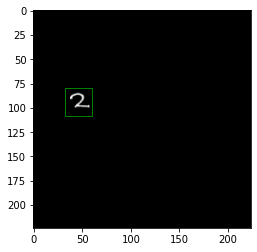

In [29]:
r = np.random.randint(TESTSIZE)

# top 10 predictions for each class
confidence, box_idx, delta = infer(y_pred[r])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

im = np.array(Image.fromarray(X[r].astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
  # skipping backgrounds
    if i == NUM_CLASSES:
        continue
    color = 'r'
  # if a class is mentioned in the ground truth, color the boxes green
    if i in Y[r,:,0]:
        color = 'g'
        print(i)
  
  # skip all the classes which have low confidence values
    if (confidence[:,i] > 0.5).any() or i in Y[r,:,0]:
        for k in range(OBJperCLASS):
            print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
      
      # draw bounding box only if confidence scores are high
        if confidence[k,i] < 0.5:
            continue
        x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
        y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
        rect = patches.Rectangle((y,x),bbox_hw[k,i,1],bbox_hw[k,i,0],linewidth=1,edgecolor=color,facecolor='none')
        ax.add_patch(rect)

plt.show()